In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from camera_calibration import calibrate_camera, undistort_image
from thresholding import hls_threshold, magnitude_threshold, combine_binary
from perspective_transform import transform_perspective
from find_lane_pixels import find_lane_line_from_polynomial, find_next_lane_line_from_prev_poly
from radius_of_curvature import get_radius_of_curvature
from moviepy.editor import VideoFileClip


**Undistort the image**

Text(0.5,1,'Undistorted Image')

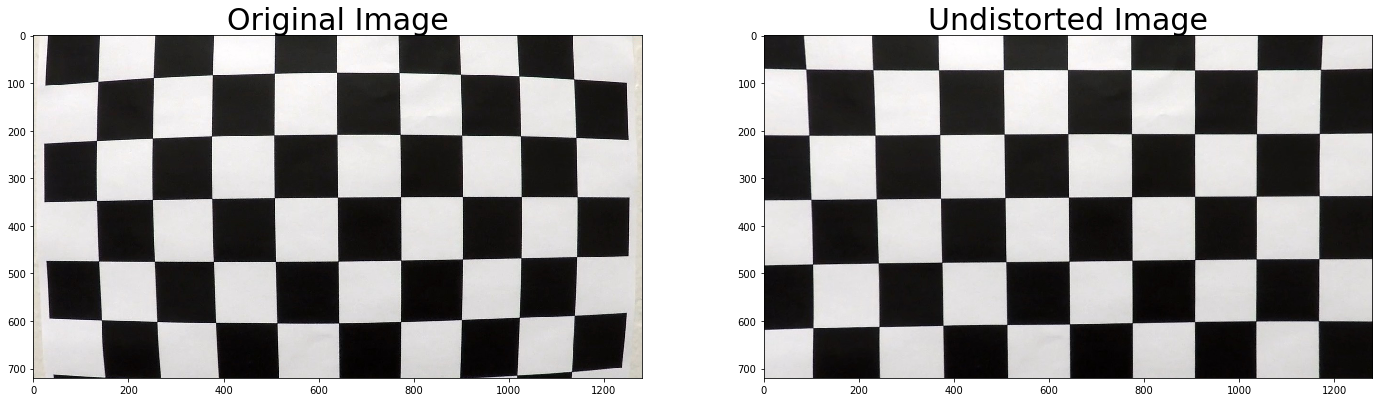

In [2]:
#Read an image
image = mpimg.imread('camera_cal/calibration1.jpg')

# Get camera matrix & distortion coefficient
mtx, dist = calibrate_camera()

# Undistort the image
undist_image = undistort_image(image, mtx, dist)

cv2.imwrite('output_images/undist_image.png', undist_image)

#Plot the undistorted image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undist_image, cmap='gray')
ax2.set_title('Undistorted Image', fontsize=30)
    

**Threshold the image** 

Text(0.5,1,'Combined binary Image')

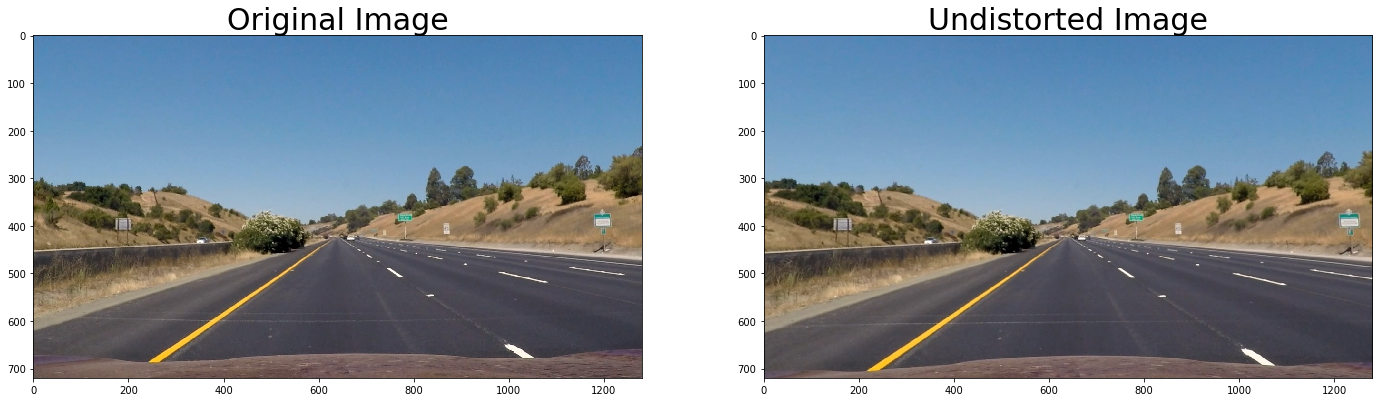

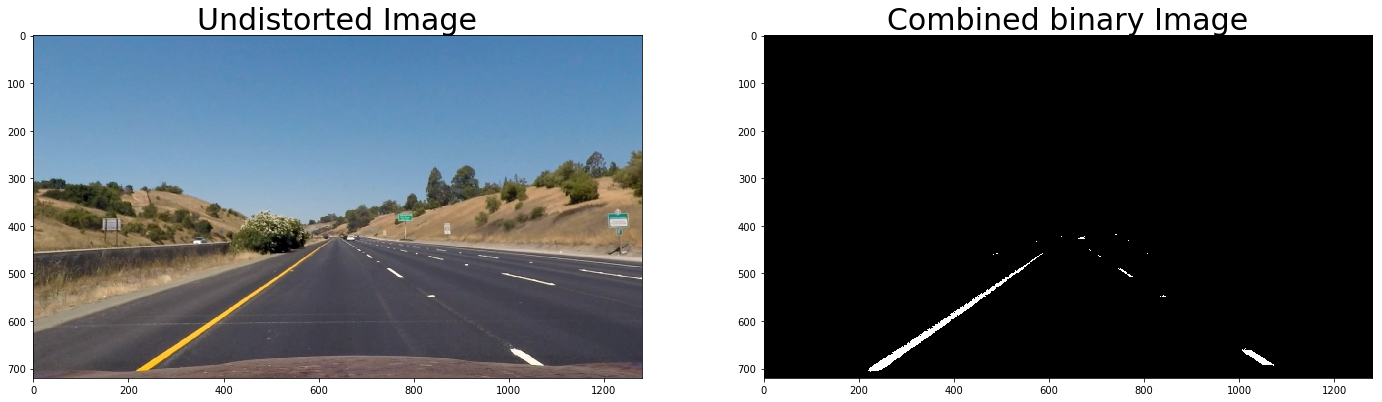

In [3]:
# Read an image
line_image = mpimg.imread('test_images/straight_lines1.jpg')

# Undistort an image before applying threshold
undist_line_image = undistort_image(line_image, mtx, dist)

#Plot the undistorted image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
ax1.imshow(line_image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undist_line_image, cmap='gray')
ax2.set_title('Undistorted Image', fontsize=30)

# Apply the combined thresholds on the image to get a combined binary image 
combined_binary_image = combine_binary(undist_line_image)
cv2.imwrite('output_images/combined_binary.png', combined_binary_image)

# Plot the original and combined binary image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
ax1.imshow(undist_line_image)
ax1.set_title('Undistorted Image', fontsize=30)
ax2.imshow(combined_binary_image, cmap='gray')
ax2.set_title('Combined binary Image', fontsize=30)

**Perform perspective transform**

Warped image shape 720 1280


True

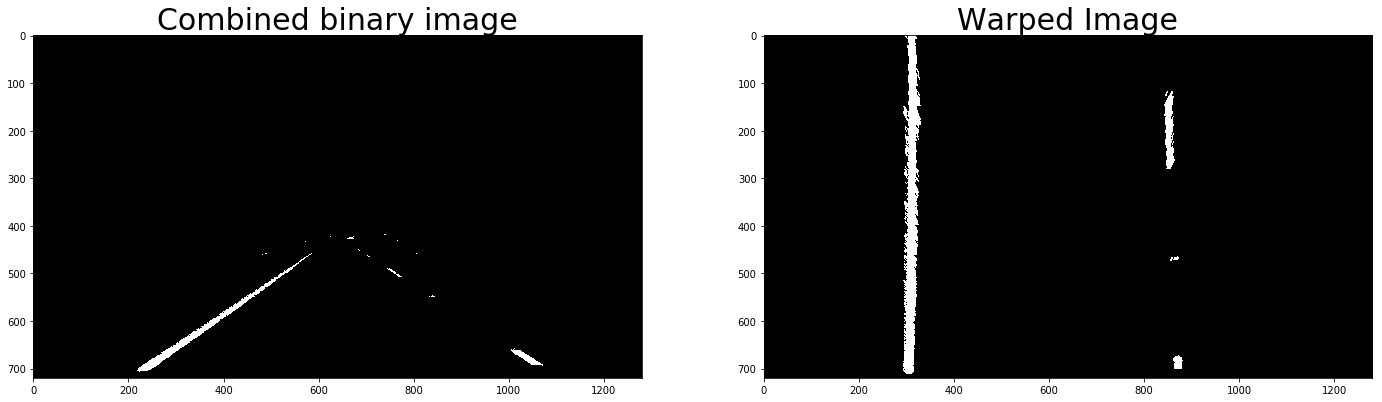

In [4]:
# Get the warped image
warped_image, M, Minv = transform_perspective(combined_binary_image)
print("Warped image shape", warped_image.shape[0], warped_image.shape[1])

# Plot the warped image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
ax1.imshow(combined_binary_image, cmap='gray')
ax1.set_title('Combined binary image', fontsize=30)
ax2.imshow(warped_image, cmap='gray')
ax2.set_title('Warped Image', fontsize=30)

cv2.imwrite('output_images/warped_image.png', warped_image)

**Plot histogram**

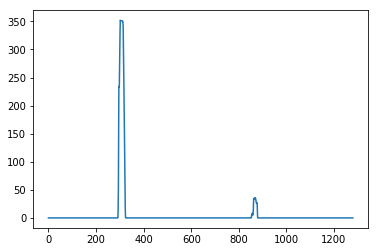

In [5]:
# Plot a histogram where the binary activations occur across the image
# Get the image height
image_height = warped_image.shape[0]
# Get the pixel value lower half of the image(half of rows and the complete columns 
# where lane lines are most likely to be vertical
lower_half = warped_image[image_height // 2:,:]

# Get the sum across the vertical line or the height of the image or sum of the columns
histogram = np.sum(lower_half, axis=0)

# Plot the histogram
plt.plot(histogram)

**Find Lane Pixels**

True

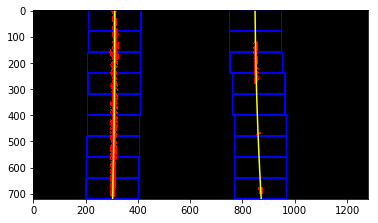

In [6]:
# Find the lane line from the polynomials formed
sliding_window_image, prev_coeff, x_pixel_values = find_lane_line_from_polynomial(warped_image)

#Plot the left and right x and y values of the lane lines
left_laneline_x_values = x_pixel_values[0]
right_laneline_x_values = x_pixel_values[1]

image_y_values = np.linspace(0, warped_image.shape[0]-1, warped_image.shape[0] )
plt.plot(left_laneline_x_values, image_y_values, color='yellow')
plt.plot(right_laneline_x_values, image_y_values, color='yellow')
plt.imshow(sliding_window_image)

cv2.imwrite('output_images/sliding_window_image.png', sliding_window_image)

**Find from previous lane**

True

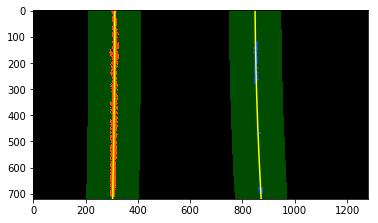

In [7]:
# In the next frame, find lane lines from the lane lines of the last frame or polynomial
next_frame_image, new_coeff, x_values = find_next_lane_line_from_prev_poly(prev_coeff, warped_image)

#Plot the left and right x and y values of the lane lines
left_laneline_x_values_new = x_values[0]
right_laneline_x_values_new = x_values[1]

# Plot the polynomial lines onto the image
plt.plot(left_laneline_x_values_new, image_y_values, color='yellow')
plt.plot(right_laneline_x_values_new, image_y_values, color='yellow')
plt.imshow(next_frame_image)

cv2.imwrite('output_images/next_frame_image.png', next_frame_image)

**Find radius of curvature and calculate the offset**

In [8]:
# Find the radius of curvature of the lane line
curvature = get_radius_of_curvature(x_values)

# Get radius of left and right curvature
left_curvature = curvature[0]
right_curvature = curvature[1]

# Print radius of left and right curvature
print(left_curvature, 'm', left_curvature, 'm')

8592.78155949 m 8592.78155949 m


**Calculate offset**

In [9]:
def offset():
    # Calculate position of the car from the centre
    left_x_values = x_values[0]
    right_x_values = x_values[1]

    # Get the centre of the lane using the poynomial equation
    lane_diff = abs(left_x_values[len(left_x_values) - 1] - right_x_values[len(left_x_values) - 1]) / 2
    lane_centre = lane_diff + left_x_values[len(left_x_values) - 1]

    # Get the centre of the car which is the centre of the image captured by the camera
    image_centre = line_image.shape[1] / 2

    # offset of the car from the lane centre in pixels
    offset_pixels = abs(lane_centre - image_centre)

    # offset of the car from the lane centre in meters
    xmeter_per_pixel = 3.7/700
    offset_meters = offset_pixels * xmeter_per_pixel
    
    return offset_meters
    
# Calculate offset in meters
offset_meters = offset()

# Print offset in meters
print(offset_meters)

0.276907203926


**Draw lane lines on original road**

True

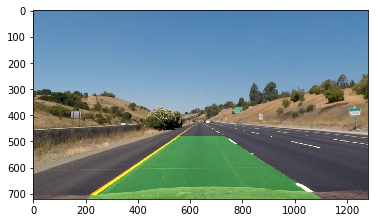

In [10]:
def original_lane_lines(warp_img, undistorted_line_image, x_line_values, MatrInv):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warp_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Generate x and y values for plotting
    image_y_values = np.linspace(0, warp_img.shape[0]-1, warp_img.shape[0] )
    
    left_x_values = x_line_values[0]
    right_x_values = x_line_values[1]

    # Recast the x and y points into usable format for cv2.fillPoly()
    left_points = np.array([np.transpose(np.vstack([left_x_values, image_y_values]))])
    right_points = np.array([np.flipud(np.transpose(np.vstack([right_x_values, image_y_values])))])
    points = np.hstack((left_points, right_points))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([points]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    new_warped_image = cv2.warpPerspective(color_warp, MatrInv, (warp_img.shape[1], warp_img.shape[0]))

    # Combine the result with the original image
    original_lane_image = cv2.addWeighted(undistorted_line_image, 1, new_warped_image, 0.3, 0)
    
    return original_lane_image
    
# Draw the lane lines on the original image by unwarping the image    
original_lane_image = original_lane_lines(warped_image, undist_line_image, x_values, Minv)
plt.imshow(original_lane_image)

cv2.imwrite('output_images/original_lane_image.png', original_lane_image)

### Video Processing Pipeline:

#### I am going to establish a class Line() for the lines to store attributes about the lane lines from one frame to the next. Inside the class I am defining a function which claculates the average coefficients of the line from the newest few frames to pass it on to the function which forms a line from previous polynomial.


In [11]:
class Line:
    def __init__(self):        
        # Is there any lane line found
        self.found = False;
        # polynomial coefficients averaged over the last n iterations
        self.avg_coeff = None 
        #polynomial coefficients of the current line
        self.current_coeffs = []
        
    # Find the average coefficients of the lines of first the newest five frames
    def average_coeffs(self, coeff):
        self.current_coeffs.append(coeff)       
        
        if len(self.current_coeffs) > 5:
            # discard old coefficients, keep newer 5
            self.current_coeffs = self.current_coeffs[len(self.current_coeffs) - 5:]
            
        self.avg_coeff = np.average(self.current_coeffs, axis=0)
        

In [12]:
def video_pipeline(pipeline_image):
    
    # Undistort the image
    undistorted_image = undistort_image(pipeline_image, mtx, dist)
    
    # Apply the combined thresholds on the image to get a combined binary image 
    binary_image = combine_binary(undistorted_image)
    
    # Get the warped image
    warp_image, Matr, MatrInv = transform_perspective(binary_image)
    
    # Check if there are previous lines
    if (left_line.found == False or right_line.found == False):    
        # Find the lane line from the polynomials formed
        lane_line_image, prev_coefficient, x_lane_line_values = find_lane_line_from_polynomial(warp_image)
        
        left_coeff = prev_coefficient[0]
        right_coeff = prev_coefficient[1]
        
        # Once the first lines are fouind, set the flag to true
        left_line.found = True
        right_line.found = True
    else:   
        # The previous coefficients will be the average of the coefficients of the newest few frames
        prev_coefficient = (left_line.avg_coeff, right_line.avg_coeff)
    
        # In the next frame, find lane lines from the average coefficients of the lane lines of  last few frames
        out_image, new_coefficient, x_lane_line_values = find_next_lane_line_from_prev_poly(prev_coefficient, warp_image)
        
        left_coeff = new_coefficient[0]
        right_coeff = new_coefficient[1]
    
    # Append the coefficents of the lines so that the average is taken in every loop inside the video pipeline.
    left_line.average_coeffs(left_coeff)
    right_line.average_coeffs(right_coeff)
        
    # Check if average coefficents of the lane lines are not NULL
    if left_line.avg_coeff is not None and right_line.avg_coeff is not None:
        # Find the radius of curvature of the lane line
        radius_curvature = get_radius_of_curvature(x_lane_line_values)

        # Get radius of left and right curvature
        left_radius_curvature = radius_curvature[0]
        right_radius_curvature = radius_curvature[1]

        # Calculate offset in meters
        offset_mtrs = offset()

        #Draw the lane lines on the original image by unwarping the image    
        orig_lane_image = original_lane_lines(warp_image, undistorted_image, x_lane_line_values, MatrInv)

        
        return orig_lane_image

**Play the images on video**



In [13]:
left_line =  Line()
right_line = Line()

output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(video_pipeline)#NOTE: this function expects color images!!
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [08:01<00:00,  2.69it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 4min 50s, sys: 1min 2s, total: 5min 53s
Wall time: 8min 4s
